In [217]:
def read_chat(path, filename):
    chat = open(path + filename,  "r", encoding="utf8")
    text = chat.read()
    return text

In [257]:
def make_df(text):
    structure = re.findall("(\d{2}/\d{2}/\d{2}),\s(\d{2}:\d{2})\s-\s(.*?):(.*)", text)
    chat_df = pd.DataFrame(structure, columns=['date', 'time', 'sender', 'message'])
#     print(chat_df.head())
    return chat_df

In [261]:
# find total messages exchanged, and proportion of messages sent by each participant
def calculate_total_proportion(chat_df):
    print("A total of %s messages have been exchanged" %(len(chat_df.index)))
    print ("\n")
    by_person_df = chat_df.groupby(['sender']).size().reset_index(name='messages_by_person').sort_values('messages_by_person', ascending=False)
    
    ax1 = plt.subplot(121, aspect='equal')
    ax1.pie(by_person_df['messages_by_person'], labels = by_person_df['sender'], autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.tight_layout()    
    plt.title("Share of messages by sender", bbox={'facecolor':'0.8', 'pad':1})
    
    # plot table
    ax2 = plt.subplot(122)
    plt.axis('off')
    tbl = table(ax2, by_person_df, colWidths = [0.4, 0.4], loc='center')
    tbl.auto_set_font_size(False)
    tbl.scale(1, 1)
    tbl.set_fontsize(9)

    plt.savefig('Total messages and proportion.png')
    plt.show()

In [227]:
# find proportion of monthly messages sent by each participant
def calculate_monthly_proportion(chat_df):

    chat_df['month_year'] = chat_df['date'].values.astype('datetime64[M]')
    by_month_df = chat_df.groupby(['month_year', 'sender']).size().reset_index(name='messages_by_month_year').sort_values('month_year', ascending = False)
    
    total_monthly_messages_df = by_month_df.groupby(['month_year'])['messages_by_month_year'].sum().reset_index(name='total_monthly_messages').sort_values('month_year', ascending = False)

    merge_df = pd.merge(by_month_df, total_monthly_messages_df, on = 'month_year', how = 'left')
    merge_df['proportion_of_messages'] = merge_df['messages_by_month_year']/merge_df['total_monthly_messages']

    merge_df_reshaped = merge_df.drop(['messages_by_month_year', 'total_monthly_messages'], axis=1)
    merge_df_reshaped = merge_df_reshaped.pivot(index='month_year', columns='sender', values='proportion_of_messages')  
    merge_df_reshaped = merge_df_reshaped.fillna(0)
    
    # area plot
    plt.style.use('seaborn')
    merge_df_reshaped.plot.area()
    plt.xlabel('Sender', fontsize=12)
    plt.ylabel('Proportion of total messages sent', fontsize=12)
    plt.title('Proportion of messages by month',fontsize=15)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    # un-comment the line below to save plot as a png file
    plt.savefig('Proportion of monthly messages by user.png')
    plt.show()

In [185]:
# find frequency of messages by hour of day
def calculate_hourly_frequency(chat_df):
      chat_df["date"] = pd.to_datetime(chat_df["date"], format='%d/%m/%y')
      chat_df['day_of_week'] = chat_df['date'].dt.day_name()
      chat_df['time'] = pd.to_timedelta(chat_df['time'] + ':00')
      chat_df['hour'] = chat_df['time'].dt.components['hours']
      by_hour_df = chat_df.groupby(['hour', 'sender']).size().reset_index(name='messages_by_hour').sort_values('hour', ascending = False)
      
      plt.figure(figsize=(10, 6))
#     sns.lineplot(x="time", y="messages_by_hour", data=by_hour_df).set_title("Hourly frequency of messages")
      sns.lineplot(x="hour", hue="sender", y="messages_by_hour", data=by_hour_df).set_title("Hourly frequency of messages by sender")

      # un-comment the line below to save plot as a png file   
      plt.savefig('Messages by hour of day.png')
      plt.show()
    
      return chat_df

In [186]:
# find frequency of messages by day of week
def calculate_daily_frequency(chat_df):
    by_day_df = chat_df.groupby(['day_of_week']).size().reset_index(name='messages_by_day')
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    by_day_df['day_of_week'] = pd.Categorical(by_day_df['day_of_week'], categories=days, ordered=True)
    by_day_df = by_day_df.sort_values('day_of_week')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="day_of_week", y="messages_by_day", data=by_day_df).set_title("Daily frequency of messages")
    
    # un-comment the line below to save plot as a png file
    plt.savefig('Messages by day of week.png')
    plt.show()

In [187]:
# find number of days on which not a single message was exchanged 
def days_without_message(chat_df):
    total_days = (chat_df['date'].max() - chat_df['date'].min()).days
    print("You haven't exchanged a single message on %s days in your %s days of history" %((total_days - chat_df['date'].nunique()), total_days))

In [188]:
# find who sends the first message and how many times
# the first message is defined as one sent at least number_of_minutes minutes after the last one
def first_message_sender(chat_df, number_of_minutes):
    first_message = defaultdict(int)
    
    chat_df['diff_minutes'] = abs(chat_df['time'] - chat_df['time'].shift(-1)).astype('timedelta64[m]')
    
    for idx, series in chat_df.iterrows():
        if (series['diff_minutes'] > number_of_minutes):
           first_message[series['sender']] = first_message[series['sender']] + 1
        
    first_message = dict(sorted(first_message.items(), key=operator.itemgetter(1),reverse=True))
    print("The number of times first message was sent by each user:", first_message)
    print("\n")

In [189]:
# find number of media file (photos/videos) shared by each participant
def calculate_media_shared(chat_df):
    media_df = chat_df[chat_df['message'] == ' <Media omitted>'].groupby(['sender']).size().reset_index(name='number_of_photos_by_sender')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x = "sender", hue="sender", y="number_of_photos_by_sender", data=media_df).set_title("Who sent how many media files")
    # un-comment the line below to save plot as a png file
#     plt.savefig('Media files by participant.png')
    plt.show()

In [190]:
# find total messages sent daily since the beginning of the chat
def messages_by_date(chat_df):
    by_date_df = chat_df.groupby(['date'])['message'].size().reset_index(name='messages_by_day')
    plt.figure(figsize=(20, 6))
    sns.barplot(x="date", y="messages_by_day", data = by_date_df).set_title("Number of messages exchanged daily")
    # un-comment the line below to save plot as a png file
#     plt.savefig('Number of daily messages.png')
    plt.show()

In [191]:
# find average length of messages by each participant, as well as by date
def calculate_avg_length(chat_df):
    chat_df['length_of_message'] = chat_df[chat_df['message'] != ' <Media omitted>']['message'].apply(lambda x: len(x.split()))
    
    # average length by sender
    avg_length_by_sender = chat_df.groupby(['sender'])['length_of_message'].mean().reset_index(name='avg_message_length(words)')
    print(round(avg_length_by_sender),1)
    
    # average length by date
    avg_length_by_day = chat_df.groupby('date')['length_of_message'].mean().reset_index(name='avg_message_length_by_day')
    
    # plot average length by day
    plt.figure(figsize=(20, 6))
    sns.barplot(x="date", y="avg_message_length_by_day", data = avg_length_by_day).set_title("Average length of a message")
    
    # un-comment the line below to save plot as a png file
    plt.savefig('Average length of messages by day.png')  
    
    plt.show()

In [192]:
# find most common words used by each participant
def count_common_words(chat_df, list_of_participants, number_of_words):
    for participant in list_of_participants:
        common_words = Counter(" ".join(chat_df[(chat_df["sender"] == participant) & 
                            (chat_df["message"] != ' <Media omitted>')]["message"]).lower().split()).most_common(number_of_words)
        print('The most common words used by', participant, 'are', common_words, "\n")
        
    # un-comment the lines below to save above data as a text file
#         f = open('common_words' + sender + '.txt', 'w')
#         for t in common_words:   
#               f.write(' '.join(str(s) for s in t) + '\n')
#         f.close()

In [193]:
# find most common emojis used by each participant
def count_emojis(chat_df, list_of_participants):
    emojis = defaultdict(int)
    
    for participant in list_of_participants:
        for message in chat_df[chat_df['sender'] == participant]['message']:
            for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]', message):
                emojis[emoji] += 1
        emojis_ascending = dict(sorted(emojis.items(), key=operator.itemgetter(1),reverse=True))
        print ("emojis used by", participant, emojis_ascending)
        print("\n")
        
    # un-comment the lines below to save above data as a text file
#         f = open('common_emojis' + sender + '.txt', 'w')
#         for t in emojis_ascending:   
#               f.write(' '.join(str(s) for s in t) + '\n')
#         f.close()

In [262]:
def main():
    # enter path and filename; in filename, don't remove "\" and ".txt" 
    path = r'C:\Users\adminuser\Desktop\Online courses\Coursera\SQL-Python'
    filename = r'\WhatsApp Chat with Kavya Pune.txt'
    
    text = read_chat(path, filename)
    
    chat_df = make_df(text)
    
    calculate_total_proportion(chat_df)
    
    chat_df1 = calculate_hourly_frequency(chat_df)
    
    calculate_daily_frequency(chat_df1)
    
    calculate_monthly_proportion(chat_df1)
    
    days_without_message(chat_df1)
    
    calculate_media_shared(chat_df)
    
    messages_by_date(chat_df)
    
    calculate_avg_length(chat_df)
    
    # enter the time elapsed, in minutes, by which you want to define "first message"
    number_of_minutes = 180
    first_message_sender(chat_df1, number_of_minutes)
    
    # enter number of most common words to be counted
    list_of_participants = chat_df['sender'].unique().tolist()
    number_of_words = 30
    count_common_words(chat_df, list_of_participants, number_of_words)
    
    count_emojis(chat_df, list_of_participants)

A total of 39999 messages have been exchanged




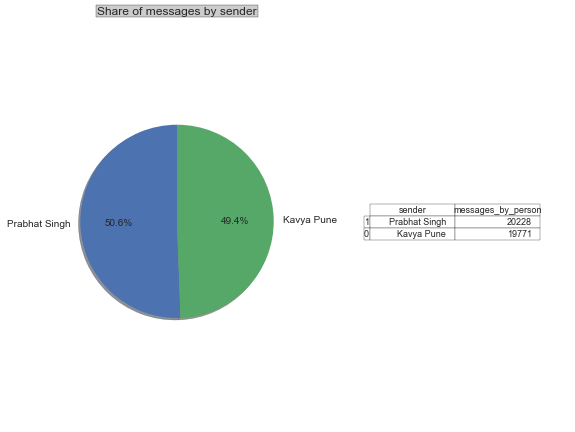

In [263]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
from collections import defaultdict
import operator
from collections import Counter
import datetime
from matplotlib.font_manager import FontProperties

main()